# Dataset Source: https://thebiogrid.org/77183/publication/a-human-protein-protein-interaction-network-a-resource-for-annotating-the-proteome.html

Using BioGRID ID Interactor A and B encodings as input and Applying MLP based classification for compatability classification

Epoch: 0/100............. Loss: 0.8335
Epoch: 10/100............. Loss: 0.6607
Epoch: 20/100............. Loss: 0.4138
Epoch: 30/100............. Loss: 0.1338
Epoch: 40/100............. Loss: 0.0250
Epoch: 50/100............. Loss: 0.0060
Epoch: 60/100............. Loss: 0.0025
Epoch: 70/100............. Loss: 0.0015
Epoch: 80/100............. Loss: 0.0011
Epoch: 90/100............. Loss: 0.0009
Accuracy: 1.0000


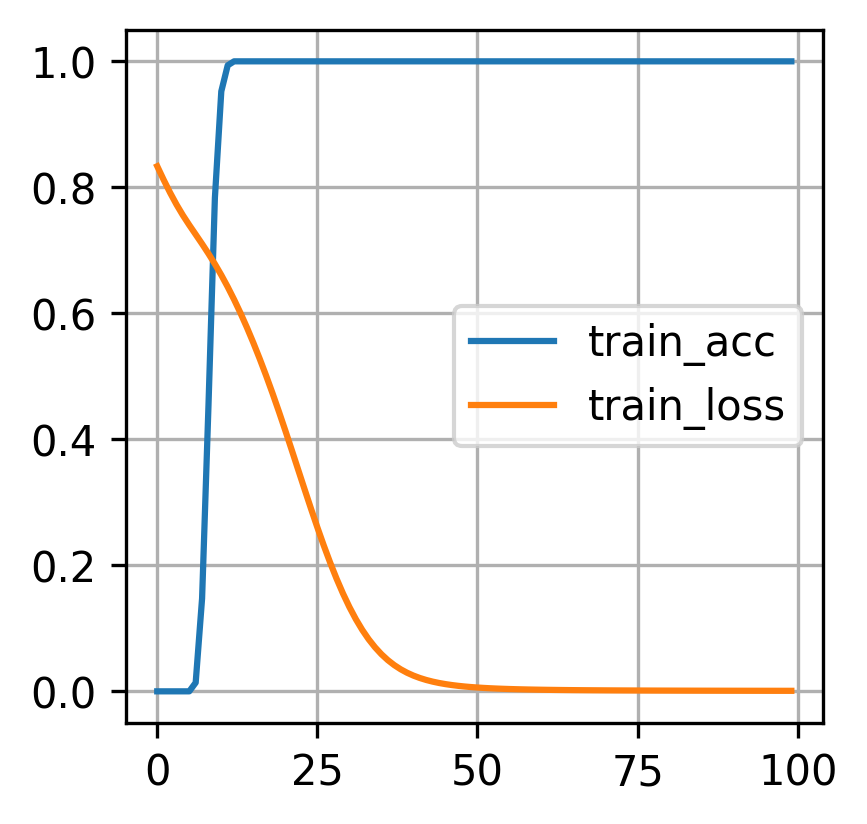

In [13]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

# Load the dataset


df = pd.read_csv('BIOGRID-PUBLICATION-77183-4.4.221.tab3.txt', sep='\t')

# Preprocess the data
# Preprocess the data
label_encoder = LabelEncoder()
df['interaction_type'] = label_encoder.fit_transform(df['Experimental System Type'])

# Convert protein sequences to one-hot encoded vectors
seq1 = df['BioGRID ID Interactor A'].apply(lambda x: bin(x)[2:]).str.zfill(40)
seq2 = df['BioGRID ID Interactor B'].apply(lambda x: bin(x)[2:]).str.zfill(40)
X = np.zeros((len(df), 80))
for i, (s1, s2) in enumerate(zip(seq1, seq2)):
    seq = s1 + s2
    for j, c in enumerate(seq):
        if c == '1':
            X[i, j] = 1

y = df['interaction_type'].values


# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the PyTorch model
class ProteinInteractionClassifier(nn.Module):
    def __init__(self):
        super(ProteinInteractionClassifier, self).__init__()
        self.fc1 = nn.Linear(80, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 2)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

# Train the PyTorch model
model = ProteinInteractionClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_acc = []
train_loss = []
for epoch in range(100):
    optimizer.zero_grad()
    output = model(torch.Tensor(X_train))
    loss = criterion(output, torch.LongTensor(y_train))
    loss.backward()
    optimizer.step()
    train_acc.append(accuracy_score(torch.argmax(output, dim=1).numpy(),y_train))
    train_loss.append(loss.item())

    if epoch % 10 == 0:
        print('Epoch: {}/{}.............'.format(epoch, 100), end=' ')
        print("Loss: {:.4f}".format(loss.item()))

# Test the PyTorch model
with torch.no_grad():
    output = model(torch.Tensor(X_test))
    y_pred = torch.argmax(output, dim=1).numpy()

acc = accuracy_score(y_test, y_pred)
print('Accuracy: {:.4f}'.format(acc))


import matplotlib.pyplot as plt
plt.figure(figsize=(3,3),dpi=300)
plt.plot(train_acc)
plt.plot(train_loss)
plt.legend(['train_acc','train_loss'])
plt.grid()
plt.show()


In [14]:
print("Indicator A:")
seq1

Indicator A:


0       0000000000000000000000011100011000011100
1       0000000000000000000000011101111000001011
2       0000000000000000000000110100101011100100
3       0000000000000000000000110100101011100100
4       0000000000000000000000011100110101010100
                          ...                   
2539    0000000000000000000000011010111011100110
2540    0000000000000000000000011110010111111110
2541    0000000000000000000000011011010000101001
2542    0000000000000000000000011011010001111101
2543    0000000000000000000000011011011011100000
Name: BioGRID ID Interactor A, Length: 2544, dtype: object

Using Symbol Interactor A and B as input and Applying MLP based classification for compatability classification

Epoch: 0/100............. Loss: 0.6039
Epoch: 10/100............. Loss: 0.5566
Epoch: 20/100............. Loss: 0.4923
Epoch: 30/100............. Loss: 0.4031
Epoch: 40/100............. Loss: 0.2889
Epoch: 50/100............. Loss: 0.1708
Epoch: 60/100............. Loss: 0.0833
Epoch: 70/100............. Loss: 0.0378
Epoch: 80/100............. Loss: 0.0185
Epoch: 90/100............. Loss: 0.0102
Loss: 0.0062
Accuracy: 1.0000


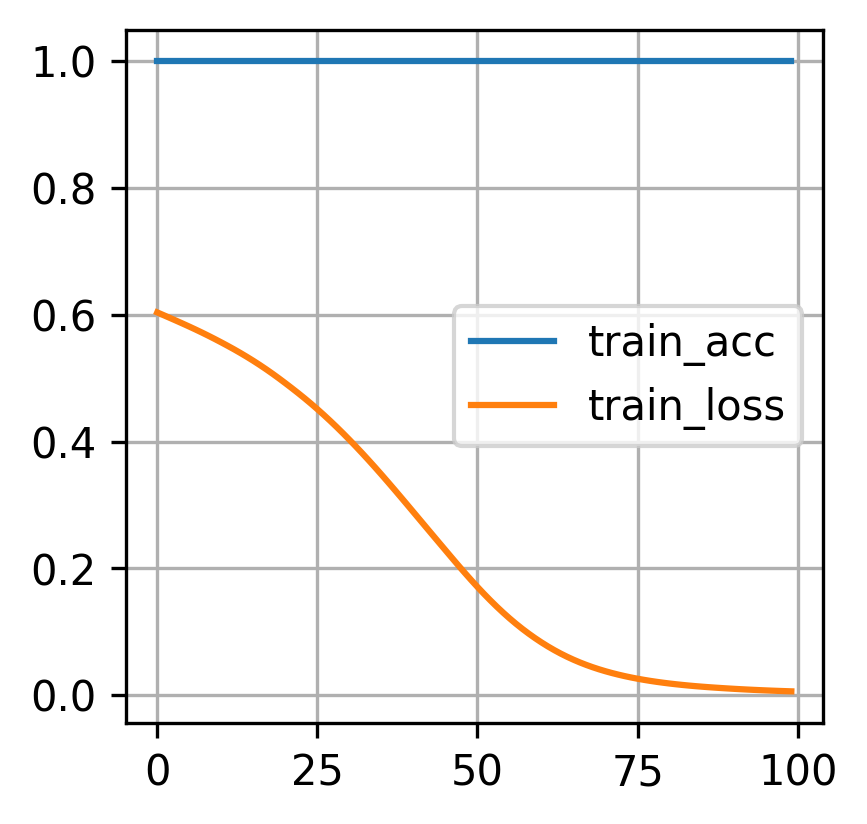

In [15]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
# Load the dataset
df = pd.read_csv('BIOGRID-PUBLICATION-77183-4.4.221.tab3.txt', sep='\t')

# Preprocess the data
label_encoder = LabelEncoder()
df['interaction_type'] = label_encoder.fit_transform(df['Experimental System Type'])

# Convert gene sequences to one-hot encoded vectors
genes1 = df['Official Symbol Interactor A']
genes2 = df['Official Symbol Interactor B']
all_genes = set(genes1).union(set(genes2))
gene_to_idx = {gene: idx for idx, gene in enumerate(sorted(all_genes))}
X = np.zeros((len(df), len(all_genes) * 2))
for i, (g1, g2) in enumerate(zip(genes1, genes2)):
    X[i, gene_to_idx[g1]] = 1
    X[i, len(all_genes) + gene_to_idx[g2]] = 1

y = df['interaction_type'].values


# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the PyTorch model
class ProteinInteractionClassifier(nn.Module):
    def __init__(self, num_genes):
        super(ProteinInteractionClassifier, self).__init__()
        self.fc1 = nn.Linear(num_genes * 2, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 2)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

# Train the PyTorch model
model = ProteinInteractionClassifier(num_genes=len(all_genes))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_acc=[]
train_loss=[]

for epoch in range(100):
    optimizer.zero_grad()
    output = model(torch.Tensor(X_train))
    loss = criterion(output, torch.LongTensor(y_train))
    loss.backward()
    optimizer.step()
    train_acc.append(accuracy_score(torch.argmax(output, dim=1).numpy(),y_train))
    train_loss.append(loss.item())

    if epoch % 10 == 0:
        print('Epoch: {}/{}.............'.format(epoch, 100), end=' ')
        print("Loss: {:.4f}".format(loss.item()))

# Test the PyTorch model
with torch.no_grad():
    output = model(torch.Tensor(X_test))
    y_pred = torch.argmax(output, dim=1).numpy()

    print("Loss: {:.4f}".format(loss.item()))

acc = accuracy_score(y_test, y_pred)
print('Accuracy: {:.4f}'.format(acc))


import matplotlib.pyplot as plt
plt.figure(figsize=(3,3),dpi=300)
plt.plot(train_acc)
plt.plot(train_loss)
plt.legend(['train_acc','train_loss'])
plt.grid()
plt.show()


In [16]:
print("Gene symboals A:")
genes1 

Gene symboals A:


0       CYB561D2
1            ACD
2        Fam101a
3        Fam101a
4         KLHL20
          ...   
2539       MARK3
2540    PPP1R16A
2541       PSMA3
2542       PTPN4
2543      SH3GL1
Name: Official Symbol Interactor A, Length: 2544, dtype: object

Using Symbol Interactor A and B as input and Applying a LSTM-Masked MLP based classification for compatability classification

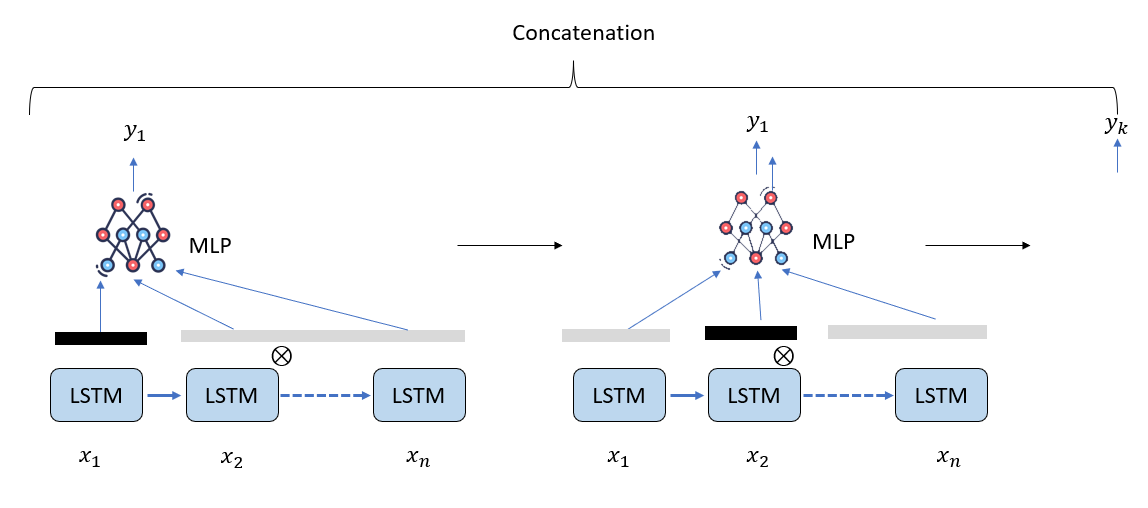

/home/junaid/anaconda3/envs/torch_env/lib/python3.10/site-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch: 0/100............. Loss: 0.7056
Epoch: 10/100............. Loss: 0.6956
Epoch: 20/100............. Loss: 0.6856
Epoch: 30/100............. Loss: 0.6758
Epoch: 40/100............. Loss: 0.6661
Epoch: 50/100............. Loss: 0.6566
Epoch: 60/100............. Loss: 0.6472
Epoch: 70/100............. Loss: 0.6379
Epoch: 80/100............. Loss: 0.6288
Epoch: 90/100............. Loss: 0.6198
Loss: 0.6118
Accuracy: 1.0000


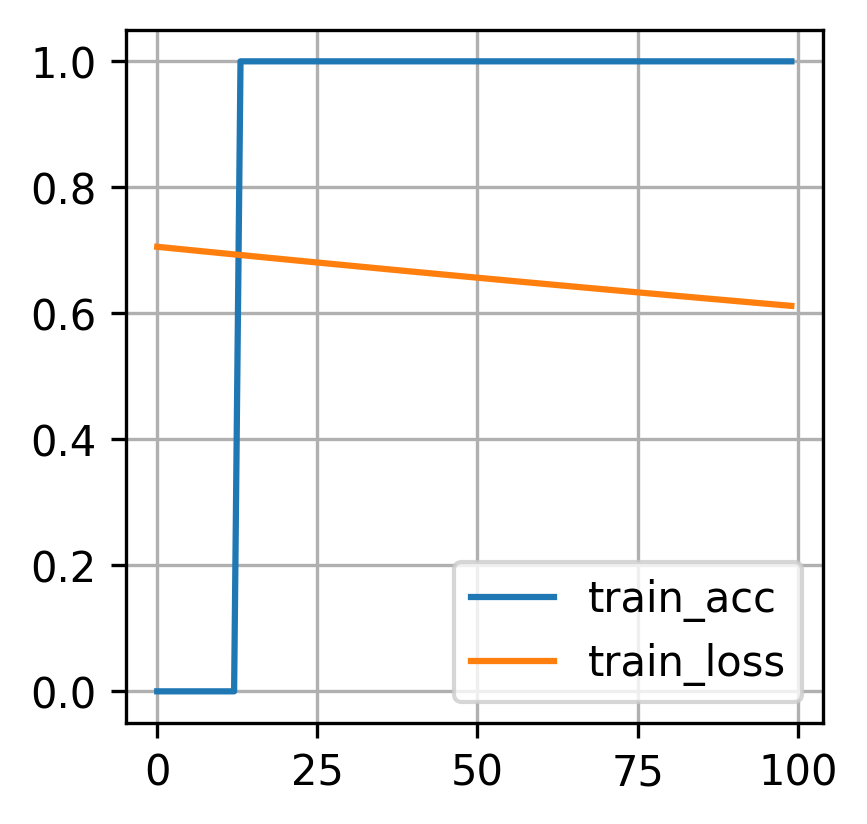

In [17]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
# Load the dataset
df = pd.read_csv('BIOGRID-PUBLICATION-77183-4.4.221.tab3.txt', sep='\t')

# Preprocess the data
label_encoder = LabelEncoder()
df['interaction_type'] = label_encoder.fit_transform(df['Experimental System Type'])

# Convert gene sequences to one-hot encoded vectors
genes1 = df['Official Symbol Interactor A']
genes2 = df['Official Symbol Interactor B']
all_genes = set(genes1).union(set(genes2))
gene_to_idx = {gene: idx for idx, gene in enumerate(sorted(all_genes))}
X = np.zeros((len(df), len(all_genes) * 2))
for i, (g1, g2) in enumerate(zip(genes1, genes2)):
    X[i, gene_to_idx[g1]] = 1
    X[i, len(all_genes) + gene_to_idx[g2]] = 1

y = df['interaction_type'].values

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



class MaskedMLP(nn.Module):
    def __init__(self, input_dim):
        super(MaskedMLP, self).__init__()
        self.input_dim = input_dim
        
        self.mlp = nn.Sequential(
            nn.Linear(input_dim-1, 1),
            nn.ReLU(),
        )

    def forward(self, x):
        mlp_outputs = []
        for i in range(x.size(2)):
            masked_x = x.clone()
            # remove the ith element from masked_x
            masked_x= torch.cat((masked_x[:,:,:i], masked_x[:, :, i+1:]), dim=2)
            masked_x= masked_x.squeeze(1)
            h = self.mlp(masked_x)
            mlp_outputs.append(h.squeeze(1))
        #stack mlp outputs
        output = torch.stack(mlp_outputs, dim=1)
        
        return output



class LSTMMaskedMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, lstm_layers, lstm_dropout):
        super(LSTMMaskedMLP, self).__init__()
        self.hidden_dim = hidden_dim
        self.lstm_layers = lstm_layers
        self.lstm_dropout = lstm_dropout
        
        # LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, lstm_layers, batch_first=True, dropout=lstm_dropout)
        
        # Masked MLP layer
        self.masked_mlp = MaskedMLP(hidden_dim)

        # MLP layer
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim, output_dim),
            # nn.ReLU(),
        )

    def forward(self, x):
        # Pass the sequence through the LSTM layer

        # expand dimension along dim 2
        x = x.unsqueeze(1)
        lstm_output, _ = self.lstm(x)

        # Apply the masked MLP layer to the masked LSTM output
        masked_mlp_output = self.masked_mlp(lstm_output)

        # masked_mlp_output = masked_mlp_output.squeeze(2)
        output = self.mlp(masked_mlp_output)

        return output
    

# Train the PyTorch model
model = LSTMMaskedMLP(input_dim=X_train.shape[1],hidden_dim=10,output_dim=2,lstm_layers=1,lstm_dropout=0.1)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_acc = []
train_loss = []

for epoch in range(100):
    optimizer.zero_grad()
    output = model(torch.Tensor(X_train))
    loss = criterion(output, torch.LongTensor(y_train))
    loss.backward()
    optimizer.step()
    train_acc.append(accuracy_score(torch.argmax(output, dim=1).numpy(),y_train))
    train_loss.append(loss.item())

    if epoch % 10 == 0:
        print('Epoch: {}/{}.............'.format(epoch, 100), end=' ')
        print("Loss: {:.4f}".format(loss.item()))

# Test the PyTorch model
with torch.no_grad():
    output = model(torch.Tensor(X_test))
    y_pred = torch.argmax(output, dim=1).numpy()

    print("Loss: {:.4f}".format(loss.item()))

acc = accuracy_score(y_test, y_pred)
print('Accuracy: {:.4f}'.format(acc))


import matplotlib.pyplot as plt
plt.figure(figsize=(3,3),dpi=300)
plt.plot(train_acc)
plt.plot(train_loss)
plt.legend(['train_acc','train_loss'])
plt.grid()
plt.show()

Using Symbol Interactor A and B as input and Applying LSTM-Masked MLP v2 based classification for compatability classification

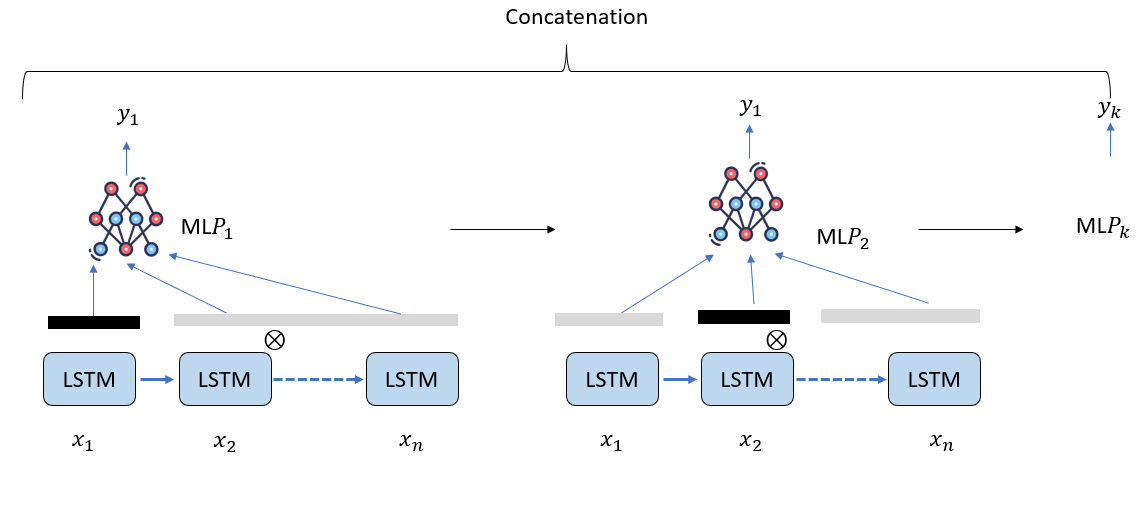

/home/junaid/anaconda3/envs/torch_env/lib/python3.10/site-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch: 0/100............. Loss: 0.7540
Epoch: 10/100............. Loss: 0.7249
Epoch: 20/100............. Loss: 0.6948
Epoch: 30/100............. Loss: 0.6633
Epoch: 40/100............. Loss: 0.6296
Epoch: 50/100............. Loss: 0.5930
Epoch: 60/100............. Loss: 0.5531
Epoch: 70/100............. Loss: 0.5097
Epoch: 80/100............. Loss: 0.4619
Epoch: 90/100............. Loss: 0.4097
Loss: 0.3600
Accuracy: 1.0000


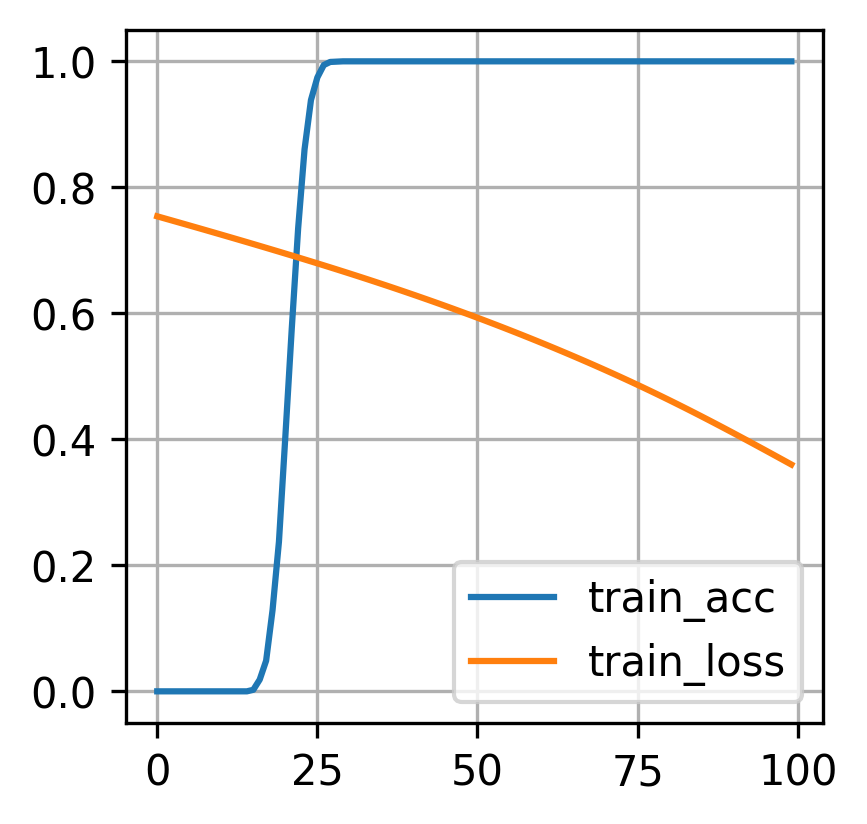

In [18]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
# Load the dataset
df = pd.read_csv('BIOGRID-PUBLICATION-77183-4.4.221.tab3.txt', sep='\t')

# Preprocess the data
label_encoder = LabelEncoder()
df['interaction_type'] = label_encoder.fit_transform(df['Experimental System Type'])

# Convert gene sequences to one-hot encoded vectors
genes1 = df['Official Symbol Interactor A']
genes2 = df['Official Symbol Interactor B']
all_genes = set(genes1).union(set(genes2))
gene_to_idx = {gene: idx for idx, gene in enumerate(sorted(all_genes))}
X = np.zeros((len(df), len(all_genes) * 2))
for i, (g1, g2) in enumerate(zip(genes1, genes2)):
    X[i, gene_to_idx[g1]] = 1
    X[i, len(all_genes) + gene_to_idx[g2]] = 1

y = df['interaction_type'].values

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


    

class MaskedMLP(nn.Module):
    def __init__(self, input_dim):
        super(MaskedMLP, self).__init__()
        self.input_dim = input_dim
        
        # MLP layers
        self.mlplayers = nn.ModuleList([nn.Sequential(
            nn.Linear(input_dim-1, 1),
            nn.ReLU(),
        ) for i in range(input_dim)])

    def forward(self, x):
        mlp_outputs = []
        ind=0
        for mlp in self.mlplayers:
            masked_x = x.clone()
            # remove the ith element from masked_x
            masked_x= torch.cat((masked_x[:,:,:ind], masked_x[:, :, ind+1:]), dim=2)
            masked_x= masked_x.squeeze(1)
            h = mlp(masked_x)
            mlp_outputs.append(h.squeeze(1))
            ind=ind+1
        #stack mlp outputs
        output = torch.stack(mlp_outputs, dim=1)
        
        return output




class LSTMMaskedMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, lstm_layers, lstm_dropout):
        super(LSTMMaskedMLP, self).__init__()
        self.hidden_dim = hidden_dim
        self.lstm_layers = lstm_layers
        self.lstm_dropout = lstm_dropout
        
        # LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, lstm_layers, batch_first=True, dropout=lstm_dropout)
        
        # Masked MLP layer
        self.masked_mlp = MaskedMLP(hidden_dim)

        # MLP layer
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim, output_dim),
            # nn.ReLU(),
        )

    def forward(self, x):
        # Pass the sequence through the LSTM layer

        # expand dimension along dim 2
        x = x.unsqueeze(1)
        lstm_output, _ = self.lstm(x)

        # Apply the masked MLP layer to the masked LSTM output
        masked_mlp_output = self.masked_mlp(lstm_output)

        # masked_mlp_output = masked_mlp_output.squeeze(2)
        output = self.mlp(masked_mlp_output)

        return output
    

# Train the PyTorch model
model = LSTMMaskedMLP(input_dim=X_train.shape[1],hidden_dim=10,output_dim=2,lstm_layers=1,lstm_dropout=0.1)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_acc = []
train_loss = []
for epoch in range(100):
    optimizer.zero_grad()
    output = model(torch.Tensor(X_train))
    loss = criterion(output, torch.LongTensor(y_train))
    loss.backward()
    optimizer.step()
    train_acc.append(accuracy_score(torch.argmax(output, dim=1).numpy(),y_train))
    train_loss.append(loss.item())

    if epoch % 10 == 0:
        print('Epoch: {}/{}.............'.format(epoch, 100), end=' ')
        print("Loss: {:.4f}".format(loss.item()))

# Test the PyTorch model
with torch.no_grad():
    output = model(torch.Tensor(X_test))
    y_pred = torch.argmax(output, dim=1).numpy()

    print("Loss: {:.4f}".format(loss.item()))

acc = accuracy_score(y_test, y_pred)
print('Accuracy: {:.4f}'.format(acc))

import matplotlib.pyplot as plt
plt.figure(figsize=(3,3),dpi=300)
plt.plot(train_acc)
plt.plot(train_loss)
plt.legend(['train_acc','train_loss'])
plt.grid()
plt.show()